<h3>Data Source</h3>
<ol><li>The dataset for this project is obtained from the kaggle competition, Toxic Comment Classification Challenge, hosted by Jigsaw/ Conversation AI.</li><li>More information on the dataset can be found at the following url. https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge</li>

<h3>Summary</h3>
<ol><li> The train dataset consists of 159,571 records with 8 columns. There are no missing values. </li><li>The two text columns are id and comment_text.<br> id consists of the unique identifier for the record and would not be useful for classifying the comments.<br>comment_text consists of the raw comments and need to be processed before they can be used for modelling. </li><li>There are 6 columns of labels for prediction and they are toxic, severe_toxic, obscene, threat, insult and identity_hate. <br>There is severe class imbalance as reflected in the table below with the toxic labels occurring between 0.2% to 9.6% of the time. <br>Some strategies to address class imbalance would include oversampling minority class, undersampling the majority class, using models that have an option to set class weights to balanced. </li></ol>

<style>
.table_component {
    overflow: auto;
    width: 100%;
}

.table_component table {
    border: 1px solid #dededf;
    height: 100%;
    width: 100%;
    table-layout: fixed;
    border-collapse: collapse;
    border-spacing: 1px;
    text-align: left;
}

.table_component caption {
    caption-side: top;
    text-align: left;
}

.table_component th {
    border: 1px solid #dededf;
    background-color: #eceff1;
    color: #000000;
    padding: 5px;
}

.table_component td {
    border: 1px solid #dededf;
    background-color: #ffffff;
    color: #000000;
    padding: 5px;
}
</style>
<div class="table_component" role="region" tabindex="0">
<table>
    <caption><b>Normalized value count for class labels</b></caption>
    <thead>
        <tr>
            <th>Normalized Value Count</th>
            <th>toxic</th>
            <th>severe_toxic</th>
            <th>obscene</th>
            <th>threat</th>
            <th>insult</th>
            <th>identity_hate</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>0</td>
            <td>
                <pre>0.90415</pre>
            </td>
            <td>
                <pre>0.990004</pre>
            </td>
            <td>
                <pre>0.947052</pre>
            </td>
            <td>
                <pre>0.997004</pre>
            </td>
            <td>
                <pre>0.950636</pre>
            </td>
            <td>
                <pre>0.991195</pre>
            </td>
        </tr>
        <tr>
            <td>1</td>
            <td>
                <pre>0.095844</pre>
            </td>
            <td>
                <pre>0.009996</pre>
            </td>
            <td>
                <pre>0.052948</pre>
            </td>
            <td>
                <pre>0.002996</pre>
            </td>
            <td>
                <pre>0.049364</pre>
            </td>
            <td>
                <pre>0.008805</pre>
            </td>
        </tr>
    </tbody>
</table>
<div style="margin-top:8px"></a></div>
</div>

<ol start="4"><li>There is also considerable correlation between certain labels such as obscene and insult (0.74), toxic and obscene (0.68) as well as toxic and insult (0.65). <br> Modelling using sklearn ClassifierChain could be an option as it exploits correlation between labels. </li><li> The distribution of the length of comments skews to the right, indicating that there is a much higher number of short comments.<br> These observations are clearly illustrated in the histogram plot. <br><li>The comments need to be cleaned up as the following have been observed - time stamps, hashtags, additional punctuations, full comments in caps. <br> Many of the long comments contain repeated content and the short comments may not express enough meaning and could become empty strings after preprocessing and removal of stopwords.</li><li>A word cloud and a bar plot for most commonly occurring words are created for toxic comments. Some of the prominent words in the word cloud include fuck, nigger, moron, jew, fat, die, bark. Most of the frequently occurring words were found to be toxic in nature - fuck, suck, sick, nigger, shit, fat, die, faggot, bitch, gay </li></ol>

<h3>General Observations - Shape, Data Type, Missing Values</h3>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import joblib

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
col_labels = [col for col in train.columns if col not in ["id","comment_text"]]

In [4]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [6]:
train.shape

(159571, 8)

In [7]:
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [8]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [9]:
train.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


<h3>Class Labels - Imbalance, Frequency, Heatmap</h3>

In [10]:
for col in train.columns:
    if col not in ["id","comment_text"]:
        print(train[col].value_counts(normalize = True))
        print()

toxic
0    0.904156
1    0.095844
Name: proportion, dtype: float64

severe_toxic
0    0.990004
1    0.009996
Name: proportion, dtype: float64

obscene
0    0.947052
1    0.052948
Name: proportion, dtype: float64

threat
0    0.997004
1    0.002996
Name: proportion, dtype: float64

insult
0    0.950636
1    0.049364
Name: proportion, dtype: float64

identity_hate
0    0.991195
1    0.008805
Name: proportion, dtype: float64



In [11]:
for col in train[col_labels]:
    print(train[col].value_counts())

toxic
0    144277
1     15294
Name: count, dtype: int64
severe_toxic
0    157976
1      1595
Name: count, dtype: int64
obscene
0    151122
1      8449
Name: count, dtype: int64
threat
0    159093
1       478
Name: count, dtype: int64
insult
0    151694
1      7877
Name: count, dtype: int64
identity_hate
0    158166
1      1405
Name: count, dtype: int64


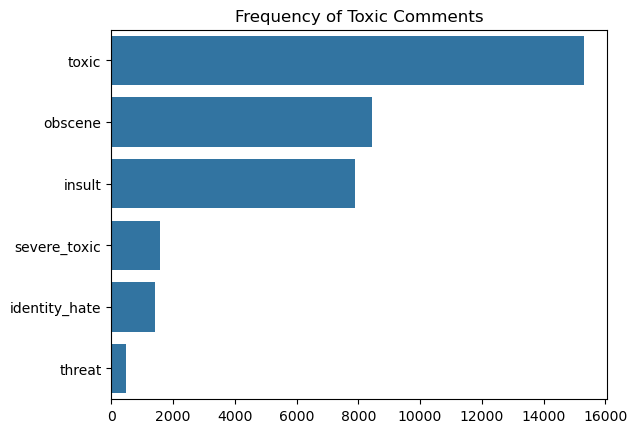

In [12]:
# train[col_labels].sum().sort_values(ascending=True).plot(kind="barh")
barplot_df = train[col_labels].sum().sort_values(ascending=False)
sns.barplot(y=barplot_df.index, x=barplot_df.values, orient="h")
plt.ylabel("")
plt.title("Frequency of Toxic Comments");

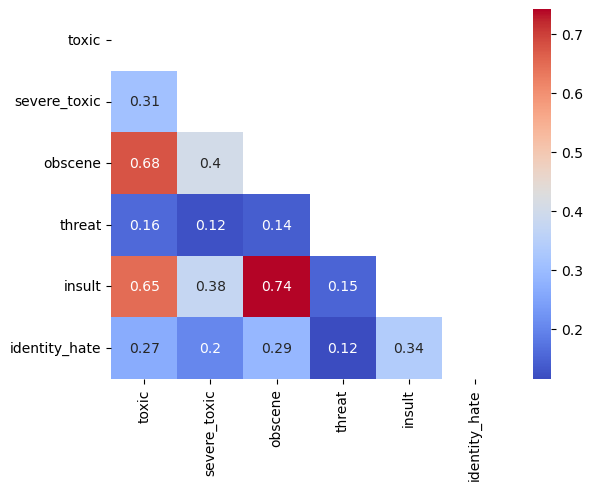

In [13]:
corr = train[col_labels].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, mask=mask, cmap='coolwarm')
plt.show()

<h3>Comment Text - Distribution of Comment Length, Closer Look at Comments</h3>

In [14]:
train["comment_length"] = train["comment_text"].map(lambda x: len(x))

In [15]:
min_length = train["comment_text"].str.len().min()
max_length = train["comment_text"].str.len().max()
min_length, max_length

(6, 5000)

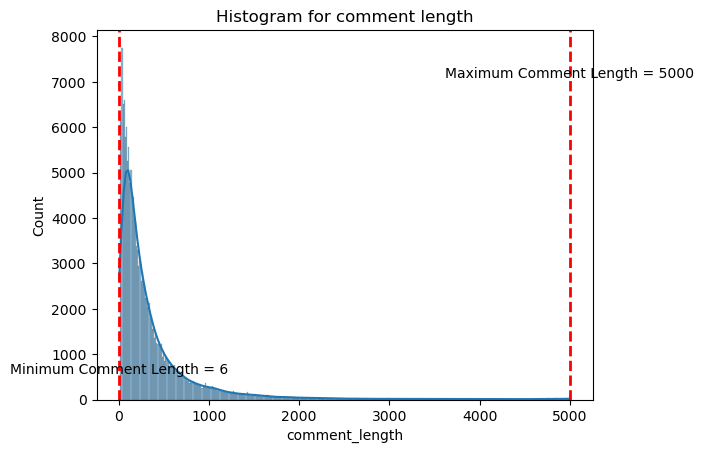

In [16]:
sns.histplot(train["comment_length"], kde=True)
plt.title("Histogram for comment length")
plt.axvline(x=min_length, color='r', linestyle='--', linewidth=2)
plt.axvline(x=max_length, color='r', linestyle='--', linewidth=2)
plt.annotate('Minimum Comment Length = 6', 
             xy=(min_length, 0.1), # Point to annotate
             xycoords=('data', 'axes fraction'), # Coordinate system
             ha='center', # Horizontal alignment
             va='top', # Vertical alignment
             rotation=0) # Rotate the text
plt.annotate('Maximum Comment Length = 5000', 
             xy=(max_length, 0.9), # Point to annotate
             xycoords=('data', 'axes fraction'), # Coordinate system
             ha='center', # Horizontal alignment
             va='top', # Vertical alignment
             rotation=0); # Rotate the text

In [17]:
for num, text in enumerate(train["comment_text"][:5]):
    print(num)
    print(text, "\n")

0
Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27 

1
D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC) 

2
Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info. 

3
"
More
I can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on refer

In [18]:
long_text = train[train["comment_text"].str.len() == 5000]
train[train["comment_text"].str.len() == 5000]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_length
4174,0b2055f13934a41e,ii CAN STILL POST WITH THIS COMPUTER...I SAID ...,1,0,1,0,1,0,5000
6201,1091689382892a88,SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SE...,1,1,1,0,0,0,5000
8705,171ebb2b785f72bd,BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALL...,1,0,0,0,0,0,5000
9673,199912b2d9973a21,"FUCK YOU, YOU ATHEIST CUNT! FUCK YOU, YOU ATHE...",1,1,1,0,1,0,5000
10769,1c7b06718dcc3b86,TOMMY2010 IS A NIGGER TOMMY2010 IS A NIGGER TO...,1,0,0,0,1,1,5000
12895,222aad8a931bcfdf,I OWN THIS PAGE YOU FOOLS!! YOU SHOULD FEAR ME...,1,0,0,0,1,0,5000
16643,2be09ad5ce9a8a85,'''Hi Wikipedia!!Hi Wikipedia!!Hi Wikipedia!!H...,0,0,0,0,0,0,5000
18183,300b0c81ea94e02d,Hey guys I love chicken rice=)Hey guys I love ...,0,0,0,0,0,0,5000
22378,3b0e1b13380cdd7a,I fuck niggas! I fuck niggas! I fuck niggas! I...,1,1,1,0,1,1,5000
25702,44096c9bd35a200d,"""....would you prefer expressing my frustratio...",0,0,0,0,0,0,5000


In [19]:
for num, text in enumerate(long_text["comment_text"][:1]):
    print(num)
    print(text)

0
ii CAN STILL POST WITH THIS COMPUTER...I SAID BLOCK ME, COME THE FUCK DOWN HERE AND ARREST ME...SAN DIEGO CALIFORNIA, CHULA VISTA, FUCKING GET YOUR INFORMATION RIGHT FAGGOT SHITHEAD!!i CAN STILL POST WITH THIS COMPUTER...I SAID BLOCK ME, COME THE FUCK DOWN HERE AND ARREST ME...SAN DIEGO CALIFORNIA, CHULA VISTA, FUCKING GET YOUR INFORMATION RIGHT FAGGOT SHITHEAD!!i CAN STILL POST WITH THIS COMPUTER...I SAID BLOCK ME, COME THE FUCK DOWN HERE AND ARREST ME...SAN DIEGO CALIFORNIA, CHULA VISTA, FUCKING GET YOUR INFORMATION RIGHT FAGGOT SHITHEAD!!i CAN STILL POST WITH THIS COMPUTER...I SAID BLOCK ME, COME THE FUCK DOWN HERE AND ARREST ME...SAN DIEGO CALIFORNIA, CHULA VISTA, FUCKING GET YOUR INFORMATION RIGHT FAGGOT SHITHEAD!!i CAN STILL POST WITH THIS COMPUTER...I SAID BLOCK ME, COME THE FUCK DOWN HERE AND ARREST ME...SAN DIEGO CALIFORNIA, CHULA VISTA, FUCKING GET YOUR INFORMATION RIGHT FAGGOT SHITHEAD!!i CAN STILL POST WITH THIS COMPUTER...I SAID BLOCK ME, COME THE FUCK DOWN HERE AND ARRE

In [20]:
train[train["comment_text"].str.len() <= 10]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_length
52442,8c4c53001134f290,"14:53,",0,0,0,0,0,0,6
109985,4c5cde3ab1a618c9,{{unbloc,0,0,0,0,0,0,8
118850,7b3d18857df782cf,FUCK YOU,1,1,1,0,1,0,8
121074,87c06f935f2c6559,you suck,1,0,1,0,1,0,8
137062,dd5ac2c49ec34efa,~ J.Lo,0,0,0,0,0,0,6


In [21]:
train[train["identity_hate"]==1]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_length
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1,648
105,00472b8e2d38d1ea,A pair of jew-hating weiner nazi schmucks.,1,0,1,0,1,1,42
176,006b94add72ed61c,I think that your a Fagget get a oife and burn...,1,0,1,1,1,1,128
218,008e0818dde894fb,"Kill all niggers. \n\nI have hard, that others...",1,0,1,0,1,1,120
238,0097dd5c29bf7a15,u r a tw@ fuck off u gay boy.U r smelly.Fuck u...,1,0,1,0,1,1,58
...,...,...,...,...,...,...,...,...,...
159281,fb726deec64157bd,LoL!! \n\nyou're GAY!! you will never know how...,1,1,1,0,1,1,87
159336,fc3efa2f6f025f6d,"Oh, fuck off. The pansy Jew would just whine a...",1,0,1,0,1,1,110
159400,fd052883fa6a8697,"Shalom \n\nSemite, get the fuck out of here. I...",1,1,1,1,1,1,474
159449,fdce660ddcd6d7ca,I think he is a gay fag!!!,1,0,0,0,0,1,26


In [22]:
train[train["insult"]==1]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_length
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,44
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1,648
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0,40
55,0020e7119b96eeeb,Stupid peace of shit stop deleting my stuff as...,1,1,1,0,1,0,89
56,0020fd96ed3b8c8b,=Tony Sidaway is obviously a fistfuckee. He lo...,1,0,1,0,1,0,68
...,...,...,...,...,...,...,...,...,...
159494,fef4cf7ba0012866,"""\n\n our previous conversation \n\nyou fuckin...",1,0,1,0,1,1,1677
159514,ff39a2895fc3b40e,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,0,0,0,1,0,33
159541,ffa33d3122b599d6,Your absurd edits \n\nYour absurd edits on gre...,1,0,1,0,1,0,346
159546,ffb47123b2d82762,"""\n\nHey listen don't you ever!!!! Delete my e...",1,0,0,0,1,0,534


<h3> Word Cloud for Toxic Comments and Most Frequent words </h3>

In [23]:
lemmatizer = WordNetLemmatizer()

In [24]:
def comments_to_words(raw_comments):
    # Function to convert a raw comment to a string of words
    
    # 1. Remove HTML.
    # re.sub(r"<.*?>", "", s1)
    review_text = BeautifulSoup(raw_comments).get_text()
    
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()

    # 4. Lemmatize
    lemma_words = [lemmatizer.lemmatize(i) for i in words]
    
    # 5. In Python, searching a set is much faster than searching
    # a list, so convert the stopwords to a set.
    stops = set(stopwords.words('english'))
    
    # 6. Remove stopwords.
    meaningful_words = [w for w in lemma_words if not w in stops]
    
    # 7. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

In [25]:
train["clean_text"] = train['comment_text'].map(comments_to_words)

/tmp/ipykernel_30857/617148167.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(raw_comments).get_text()
/tmp/ipykernel_30857/617148167.py:6: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  review_text = BeautifulSoup(raw_comments).get_text()


In [26]:
test["clean_text"] = test['comment_text'].map(comments_to_words)

/tmp/ipykernel_30857/617148167.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(raw_comments).get_text()
/tmp/ipykernel_30857/617148167.py:6: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  review_text = BeautifulSoup(raw_comments).get_text()


In [27]:
train.to_csv("data/clean_train.csv", index = False)

In [28]:
test.to_csv("data/clean_test.csv", index = False)

In [29]:
toxic_comments =  train[train[col_labels].sum(axis = 1) > 0]

In [30]:
text = ' '.join(toxic_comments['clean_text'].tolist())

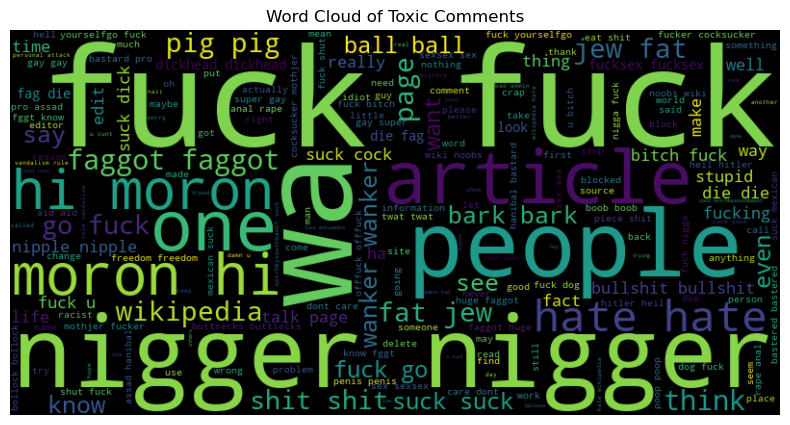

In [31]:
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title("Word Cloud of Toxic Comments")
plt.savefig("wordcloud.png") 
plt.show()

In [32]:
cvec = CountVectorizer()

In [33]:
cvec.fit(toxic_comments["clean_text"])
X_train = cvec.transform(toxic_comments["clean_text"])

In [34]:
word_counts = pd.DataFrame(X_train.todense(), columns = cvec.get_feature_names_out())

<Axes: >

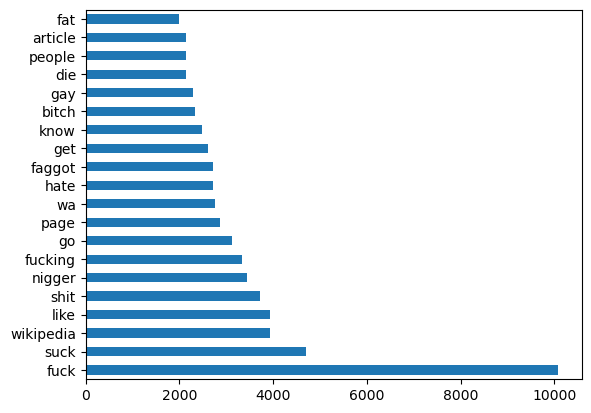

In [35]:
word_counts.sum().sort_values(ascending=False).head(20).plot(kind="barh")

In [36]:
joblib.dump(comments_to_words, 'data/comments_to_words.pkl')

['data/comments_to_words.pkl']